# How the 3-Point Line Transformed the NBA

Since its introduction in the 1979-80 season, the three-point shot has significantly influenced the NBA. Initially a minor part of the game, it has grown into a key factor in team strategies and scoring.

This project analyzes the impact of the three-point shot on the NBA using historical data. Key areas include scoring trends, shot distribution, and efficiency, as well as how these elements have evolved in response to rule changes and player adaptation. The study aims to provide a clear statistical view of how the 3-point shot has shaped modern basketball.

# 1. Code

## 1.1 Main: Webscrapping & Data handling

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Send request and safe HTML in our "Soup"
url = 'https://www.basketball-reference.com/leagues/NBA_stats_per_game.html'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

# Find the tables for regular season and playoffs statistics
table_regular = soup.find('table', id='stats-Regular-Season')
table_playoffs = soup.find('table', id='stats-Playoffs')


In [2]:
# Extract seasons if row is for the NBA league
# Called by parse_table()

def extract_season_and_liga(row, selected_columns):
    cols = row.find_all('td')
    season_cell = row.find('td', {'data-stat': 'season'})
    if cols and season_cell:
        lg_id_cell = cols[1]
        a_tag = lg_id_cell.find('a')
        if a_tag and 'NBA' in a_tag.get_text():
            season = season_cell.find('a').get_text()
            return season, [col.get_text() for col in cols]  # Return season and all data 
    return None, None
    

In [4]:
# Process the extracted data into a Dataframe
# Called by parse_table()

def process_dataframe(data, headers, seasons, selected_columns):
    df = pd.DataFrame(data, columns=headers[1:])  # Starts at season (ignore Rk)
    df.index = seasons
    df_filtered = df[selected_columns]
    df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')  # Error = NaN
    df_filtered = df_filtered.sort_index(ascending=True)  # Sort ascending by season
    return df_filtered
    

In [5]:
# Parse the table and extract relevant data
# Called by main()

def parse_table(table, selected_columns):
    rows = table.find_all('tr')
    header_row = rows[1]
    headers = [th.get_text() for th in header_row.find_all('th')]
    start_row = 3 if table == table_regular else 2  # Skipping current season in regular table
    data = []
    seasons = []
    for row in rows[start_row:]:
        season, cols = extract_season_and_liga(row, selected_columns)
        if season:
            seasons.append(season)
            data.append(cols)
    df_filtered = process_dataframe(data, headers, seasons, selected_columns)
    return df_filtered
    

In [6]:
# Combine the table of the regular season and playoffs data and calculate average
# Called by main()

def combine_and_calculate_avg(df_regular, df_playoffs, selected_columns):
    df_combined = pd.DataFrame(index=df_regular.index, columns=selected_columns)
    for column in selected_columns:
        # Calculate average only if both values are available
        df_combined[column] = df_regular[column].combine(df_playoffs[column], 
                                                         lambda x, y: (x + y) / 2 
                                                         if pd.notna(x) and pd.notna(y) 
                                                         else (x if pd.notna(x) else y))
    return df_combined
    

In [7]:
# Main method that returns the combined table of df_regular and df_combined

def main(selected_columns):
    df_regular = parse_table(table_regular, selected_columns)
    df_playoffs = parse_table(table_playoffs, selected_columns)
    df_combined = combine_and_calculate_avg(df_regular, df_playoffs, selected_columns)
    return df_combined
    

## 1.2 Visualization

In [8]:
def add_3pt_changes(plt):
    plt.axvline(x='1979-80', color='orange', linestyle='--', label='3PT Introduced')
    plt.axvline(x='1994-95', color='yellow', linestyle='--', label='Shortened 3PT Line')
    plt.axvline(x='1997-98', color='orange', linestyle='--', label='Original 3PT Distance Restored')

In [9]:
def plot(plt, title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
def visualize_1():
    selected_columns = ['PTS', 'Pace']
    df_combined = main(selected_columns)

    # Visualization with dual Y-axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # First Axis: Points per Game
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Points per Game (PTS)')
    ax1.plot(df_combined.index, df_combined['PTS'], label='Points per Game (PTS)', color='blue')
    ax1.set_xticks(np.arange(0, len(df_combined), step=5))
    ax1.set_xticklabels(df_combined.index[::5], rotation=45)

    # Second Axis: Pace
    ax2 = ax1.twinx()
    ax2.set_ylabel('Pace (Possessions per 48 Minutes)')
    ax2.plot(df_combined.index, df_combined['Pace'], label='Pace', color='red')

    # Vertical lines for changes in 3PT line
    add_3pt_changes(plt)

    # Title and layout
    plt.title('Development of total Points per Game compared to Pace')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    

In [11]:
def visualize_2():
    selected_columns = ['PTS', 'Pace']
    df_combined = main(selected_columns)

    # Remove rows with missing values
    df_combined = df_combined.dropna()

    # Visualization: Scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df_combined['Pace'], df_combined['PTS'], label='PTS vs. Pace', color='blue')

    # Fit a trend line
    z = np.polyfit(df_combined['Pace'], df_combined['PTS'], 1)  # Linear fit
    p = np.poly1d(z)
    plt.plot(df_combined['Pace'], p(df_combined['Pace']), label='Trend Line', color='red', linestyle='--')
    
    # Title and layout
    title='Points per Game vs. Pace with Trend Line'
    xlabel='Pace (Possessions per 48 Minutes)'
    ylabel='Points per Game (PTS)'

    plot(plt, title, xlabel, ylabel)
    

In [12]:
def visualize_3():
    selected_columns = ['FG', '3P', 'FT']
    df_combined = main(selected_columns)

    # Insert 0 for missing values
    df_combined = df_combined.fillna(0)

    # Adjust the values: calculate points from field goals and free throws
    fg_adjusted = (df_combined['FG'] - df_combined['3P']) * 2  # 2P in points (field goals excluding 3P)
    three_point_adjusted = df_combined['3P'] * 3  # 3P in points
    free_throw = df_combined['FT']

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.bar(df_combined.index, fg_adjusted, label='2P', color='blue', alpha=0.7)
    plt.bar(df_combined.index, three_point_adjusted, label='3P', bottom=fg_adjusted, color='green', alpha=0.7)
    plt.bar(df_combined.index, free_throw, label='FT', bottom=fg_adjusted + three_point_adjusted, color='purple', alpha=0.7)

    # Vertical lines for changes in 3PT line
    add_3pt_changes(plt)

    # Title and layout
    title='Composition of Points per Game: FG, 3P, FT'
    xlabel='Season'
    ylabel='Points'
    plt.xticks(ticks=np.arange(0, len(df_combined), step=5), labels=df_combined.index[::5], rotation=45)
    plot(plt, title, xlabel, ylabel)
    

In [13]:
def visualize_4():
    selected_columns = ['3P', '3PA', 'FGA']
    df_combined = main(selected_columns)

    # Remove rows with missing values
    df_combined = df_combined.dropna()  

    # Calculate the field goal attempts for normal 2P
    df_combined['FGA'] = df_combined['FGA'] - df_combined['3PA']

    # Stacked bar chart visualization for 3PA and FGA
    plt.figure(figsize=(12, 6))
    plt.bar(df_combined.index, df_combined['3PA'], label='3PA', color='green')
    plt.bar(df_combined.index, df_combined['FGA'], label='FGA', bottom=df_combined['3PA'], color='blue')

    # Vertical lines for changes in 3PT line
    add_3pt_changes(plt)

    # Title and layout
    title='Proportion of 3PA in Total FGA'
    xlabel='Season'
    ylabel='FGA'
    plt.xticks(ticks=np.arange(0, len(df_combined), step=5), labels=df_combined.index[::5], rotation=45)
    plot(plt, title, xlabel, ylabel)
    

In [14]:
def visualize_5():
    selected_columns = ['3PA', 'FGA']
    df_combined = main(selected_columns)

    # Remove rows with missing values
    df_combined = df_combined.fillna(0)
    # df_combined = df_combined.dropna()

    # Calculate 2PA (Field Goal Attempts excluding 3PA)
    df_combined['2PA'] = df_combined['FGA'] - df_combined['3PA']

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df_combined.index, df_combined['3PA'], label='Three-Point Attempts (3PA)', color='green')
    plt.plot(df_combined.index, df_combined['2PA'], label='Two-Point Attempts (2PA)', color='blue')

    # Vertical lines for changes in 3PT line
    add_3pt_changes(plt)

    # Title and layout
    title='Changes in 3PA, and 2PA'
    xlabel='Season'
    ylabel='Rebounds & Attempts per Game'
    plt.xticks(ticks=np.arange(0, len(df_combined), step=5), labels=df_combined.index[::5], rotation=45)
    plot(plt, title, xlabel, ylabel)
    

In [15]:
def visualize_6():
    selected_columns = ['FG%', '3P%', 'Pace']
    df_combined = main(selected_columns)

    # Visualization
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # First Axis: Shooting Efficiency (FG%, 3P%)
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Shooting Efficiency (%)')
    ax1.plot(df_combined.index, df_combined['FG%'], label='Field Goal % (FG%)', color='blue')
    ax1.plot(df_combined.index, df_combined['3P%'], label='Three-Point % (3P%)', color='green')
    ax1.set_xticks(np.arange(0, len(df_combined), step=5))
    ax1.set_xticklabels(df_combined.index[::5], rotation=45)

    # Second Axis: Pace (Possessions per 48 Minutes)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Pace (Possessions per 48 Minutes)')
    ax2.plot(df_combined.index, df_combined['Pace'], label='Pace', color='red')

    # Vertical lines for changes in 3PT line
    add_3pt_changes(plt)

    # Title and layout
    fig.suptitle('Shooting Efficiency vs. Pace Over Seasons')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.show()


In [16]:
def visualize_7():
    selected_columns = ['FG%', 'Pace']
    df_combined = main(selected_columns)

    # Remove rows with missing values for accurate plotting
    df_combined = df_combined.dropna()

    # Visualization: Scatter plot with trend line
    plt.figure(figsize=(12, 6))

    # Scatter plot
    plt.scatter(df_combined['Pace'], df_combined['FG%'], label='Pace vs. FG%', color='blue')
    
    # Fit a trend line
    z = np.polyfit(df_combined['Pace'], df_combined['FG%'], 1)  # Linear fit
    p = np.poly1d(z)
    plt.plot(df_combined['Pace'], p(df_combined['Pace']), label='Trend Line', color='red', linestyle='--')

    # Title and layout
    title='Pace vs. FG% with Trend Line'
    xlabel='Pace (Possessions per 48 Minutes)'
    ylabel='FG%'
    
    plot(plt, title, xlabel, ylabel)


In [17]:
def visualize_8():
    # Analysis 5: Influence of 3-Point Line on Free Throws
    selected_columns = ['FTA', '3PA', 'PF']
    df_combined = main(selected_columns)

    # Visualisierung
    plt.figure(figsize=(12, 6))
    plt.plot(df_combined.index, df_combined['FTA'], label='FTA', color='purple')
    plt.plot(df_combined.index, df_combined['3PA'], label='3PA', color='green')
    plt.plot(df_combined.index, df_combined['PF'], label='Fouls', color='red')

    # Vertical lines for changes in 3PT line
    add_3pt_changes(plt)
    
    # Title and layout
    title='Free Throws and 3-Point Attempts compared to Personal Fouls'
    xlabel='Season'
    ylabel='Amount'
    plt.xticks(ticks=np.arange(0, len(df_combined), step=5), labels=df_combined.index[::5], rotation=45)
    
    plot(plt, title, xlabel, ylabel)
    

In [18]:
def visualize_9():
    # Analysis 5: Influence of 3-Point Line on Free Throws (without FTA)
    selected_columns = ['3PA', 'PF']
    df_combined = main(selected_columns)

    # Remove rows with missing values
    df_combined = df_combined.dropna()

    # Visualization: Scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df_combined['3PA'], df_combined['PF'], label='PF vs. 3PA', color='blue')

    # Fit a trend line
    z = np.polyfit(df_combined['3PA'], df_combined['PF'], 1)  # Linear fit
    p = np.poly1d(z)
    plt.plot(df_combined['3PA'], p(df_combined['3PA']), label='Trend Line', color='red', linestyle='--')

    # Title and layout
    title='Personal Fouls vs. 3-Point Attempts with Trend Line'
    xlabel='3-Point Attempts (3PA)'
    ylabel='Personal Fouls (PF)'
    
    plot(plt, title, xlabel, ylabel)


# 2. Visualizations & Analysis

## 2.1. Evolution of Gameplay: Points per Game and Pace

### Development of total Points per Game compared to Pace

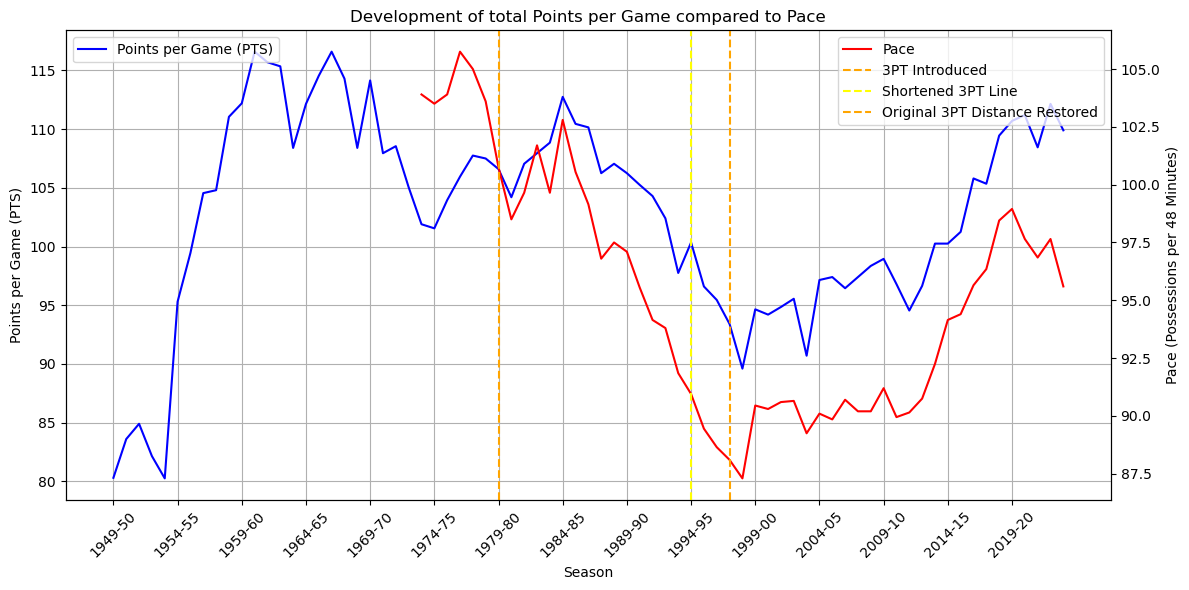

In [19]:
visualize_1()

In the early days of the NBA, points per game (PTS) rose quickly from around 80 to over 115 in the 1960s, but then started to drop, hovering around 105 for a while. This seems to reflect a shift towards slower, more defensive basketball before the 3PT line was introduced. When the 3PT line came in during the 1979-80 season, there wasn’t an immediate impact on PTS or Pace, probably because teams were hesitant to rely on it. 

PTS went up slightly for a few seasons but then dropped drastically to around 90 PTS per game, and Pace hit its lowest point at 87.5 possessions per 48 minutes. Even shortening the 3PT line in the mid-90s only led to a small, temporary increase in scoring. Things really changed in the 2000s, when PTS and Pace both started climbing again. The three-point revolution took over, with teams focusing heavily on three-point shooting and playing faster, more exciting basketball. It completely transformed the game.

### Points per Game vs. Pace with Trend Line

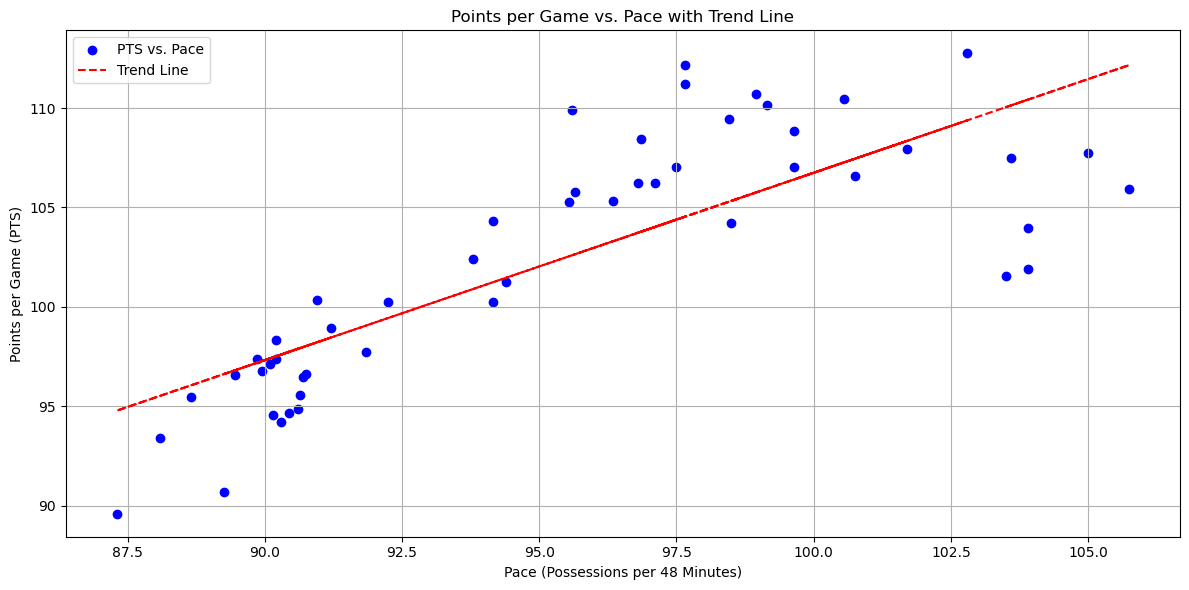

In [20]:
visualize_2()

The analysis reveals a positive correlation between Points per Game (PTS) and Pace over time, as indicated by the upward-sloping trend line. As the pace of play (possessions per 48 minutes) increases, teams tend to score more points per game. This trend suggests that faster-paced games generally lead to more opportunities for scoring. The data shows a clear upward trajectory from the early seasons to more recent ones, highlighting the shift towards a faster and more high-scoring style of play in the league.

## 2.2. Shifts in Offensive Strategies: Composition of Scoring

### Compositions of Points per Game

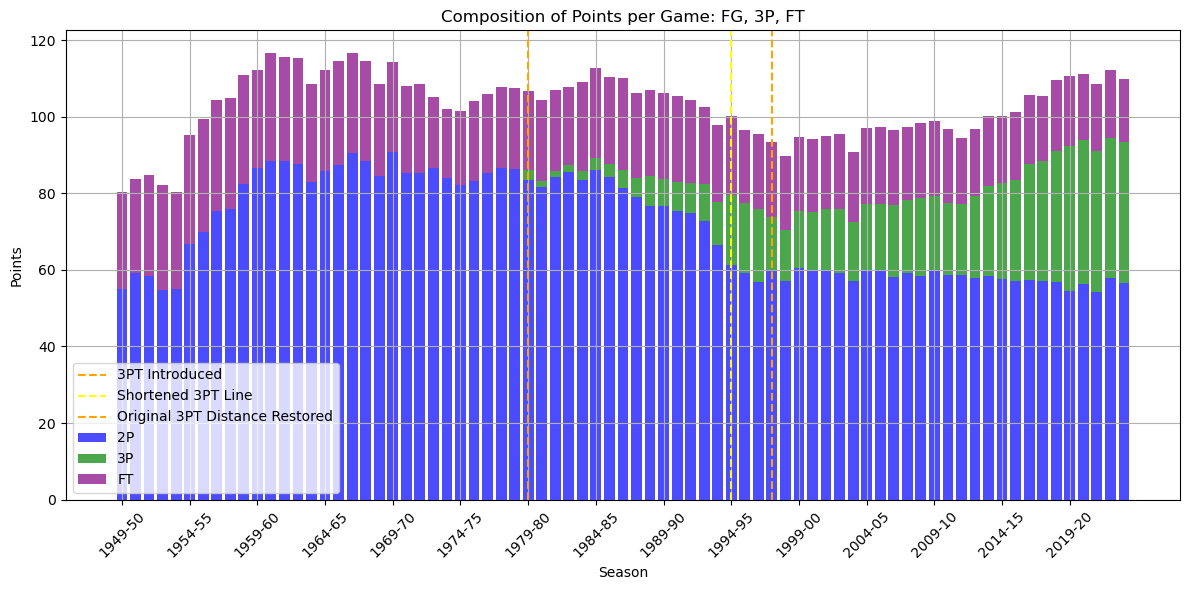

In [21]:
visualize_3()

The chart shows the composition of points per game over time, broken down into free throws (FT), two-point field goals (2P), and three-point field goals (3P). After 3P was introduced in 1979-80, it remained a minor contributor for years, but by the 2010s, it grew significantly and now accounts for a large portion of scoring. 


### Proportion of 3-Point Attempts (3PA) in Total Field Goal Attempts (FGA)

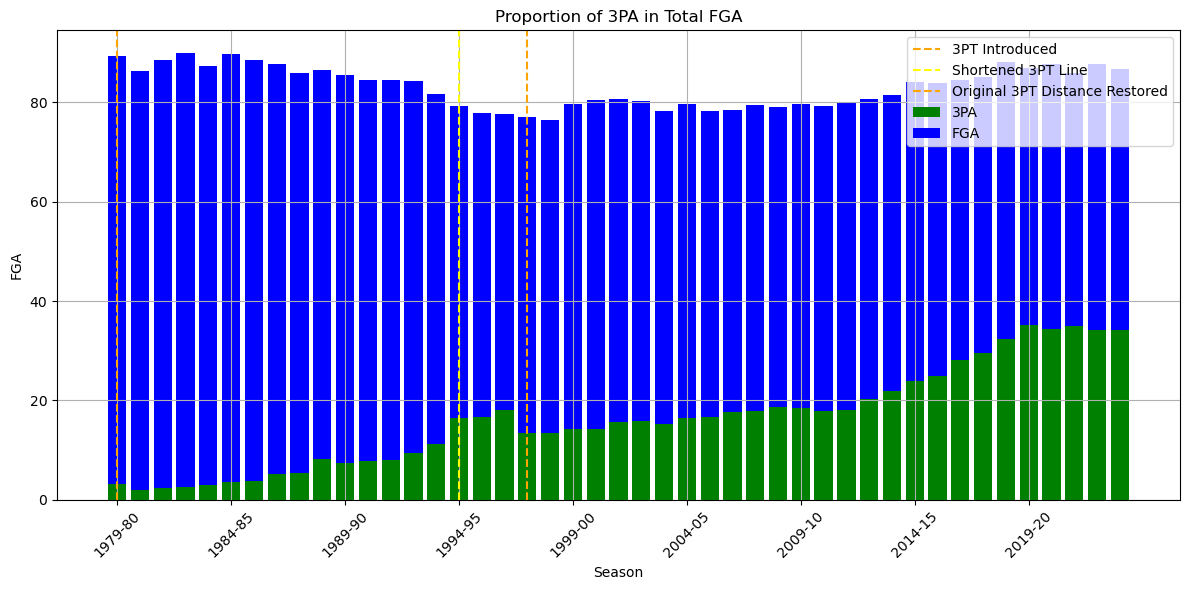

In [22]:
visualize_4()

Taking a closer look into the proportion of three-point attempts (3PA) relative to total field goal attempts (FGA), initially, 3PA made up only a tiny fraction of total FGA, reflecting the slow adoption of the shot. During the shortened 3PT line era (1994-97), the 3P contribution spiked temporarily but returned to a slower growth when the original distance was restored. However, as the value of the three-pointer became clearer, its share steadily increased, especially from the 2010s onward. This reflects the modern game's reliance on spacing and perimeter shooting, where three-pointers are now a key offensive strategy.

### Changes in 3PA and 2PA

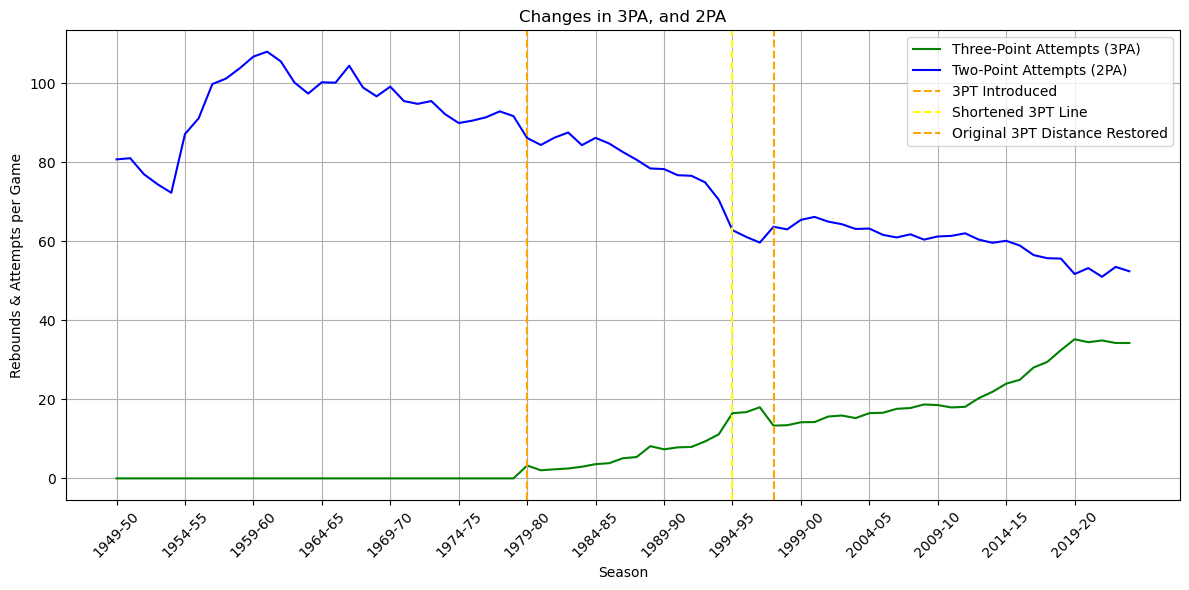

In [23]:
visualize_5()

Since the introduction of the three-point line, there has been a noticeable shift in the distribution of 3-Point Attempts (3PA) and Two-Point Attempts (2PA). As 3PA increased over the years, 2PA steadily decreased, with both trends showing a mirrored relationship. This shift reflects the growing emphasis on the three-point shot in modern basketball. However, since the 2019-20 season, both 3PA and 2PA have remained relatively stable, indicating that the evolution in shot selection has leveled off, and teams have settled into a new balance between two- and three-point attempts.

## 2.3. Efficiency and Trade-Offs: Pace, Shooting and Scoring Efficiency

### Efficiency vs. Pace Trade-Off

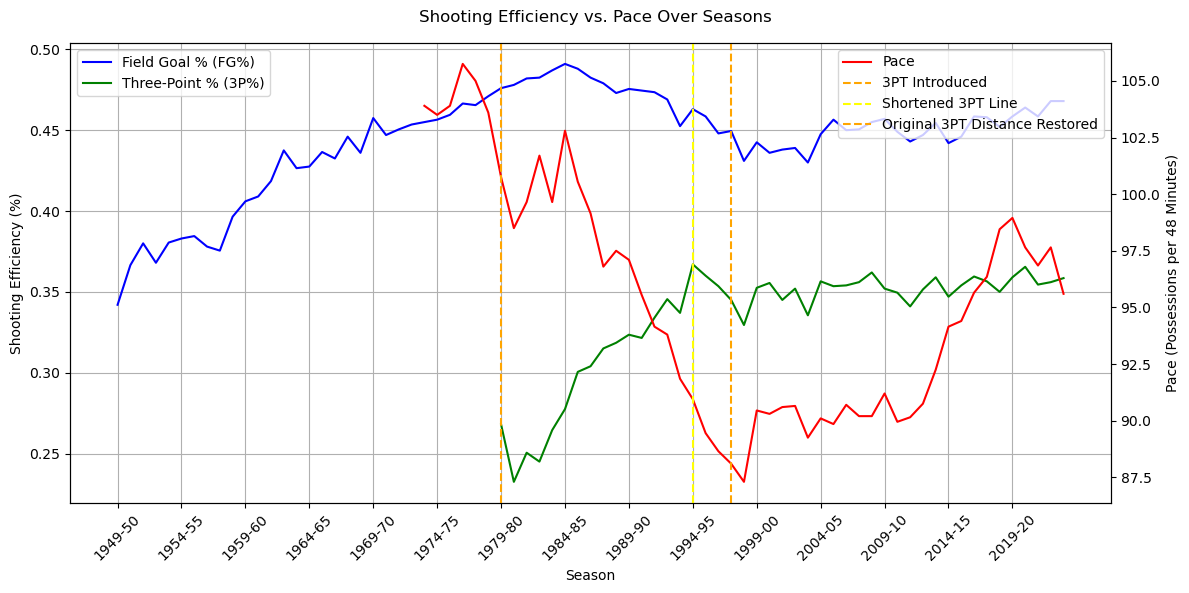

In [24]:
visualize_6()

Field goal percentage (FG%) got better from the 1950s to the 1980s, going from about 40% to nearly 50%, and then stayed pretty steady. When the three-point line was introduced in 1979-80, it added a whole new layer to shooting. Three-point percentage (3P%) started low at around 25% but got way better over time, leveling out at about 35% by the late ‘90s. During the short 3PT line era (1994-97), there was a clear spike in 3P%, but once the line moved back, things quickly returned to normal.

### Pace vs. FG% with Trend Line

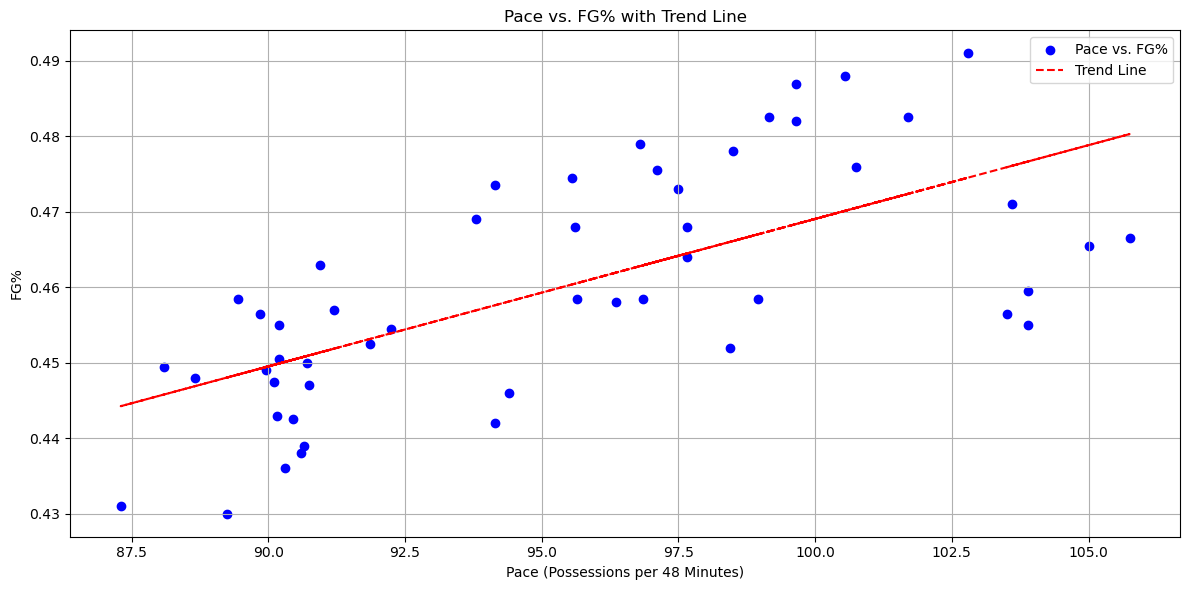

In [25]:
visualize_7()

The trendline shows a positive relationship between Pace and Field Goal Percentage (FG%). As the pace of play has increased over time, teams have been able to maintain a steady improvement in their shooting efficiency. This trend suggests that faster-paced games may contribute to higher shooting percentages, possibly due to better shot selection, quicker offensive transitions, and fewer defensive setups. The overall rise in both pace and FG% indicates an evolution in playing style, where higher-speed gameplay has not necessarily sacrificed efficiency.

## 2.4. Influence of the 3-Point Line on Other Aspects of the Game

### FT and 3PA compared to Personal Fouls

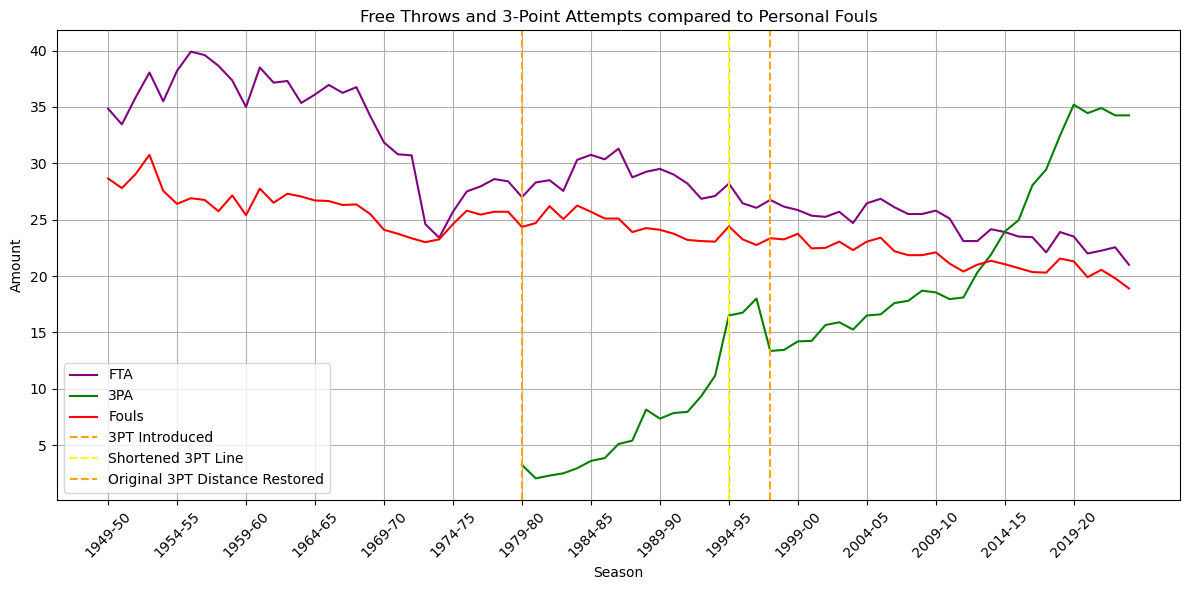

In [26]:
visualize_8()

Back in the 1950s and early ‘60s, teams shot around 35-40 free throws (FTA) per game, with personal fouls sitting at 25-30 per game. Both numbers started to drop during the 1970s. When the three-point line came in during 1979-80, teams barely used it—only 2-3 attempts (3PA) per game. But over the years, 3PA kept climbing, and the biggest jump came in the 2010s when it shot up from around 20 to over 35 per game, even overtaking FTA for the first time ever. At the same time, personal fouls kept going down to about 20 per game, showing how the game has shifted toward less physical play and more focus on skill.

### PF vs. 3PA with Trend Line

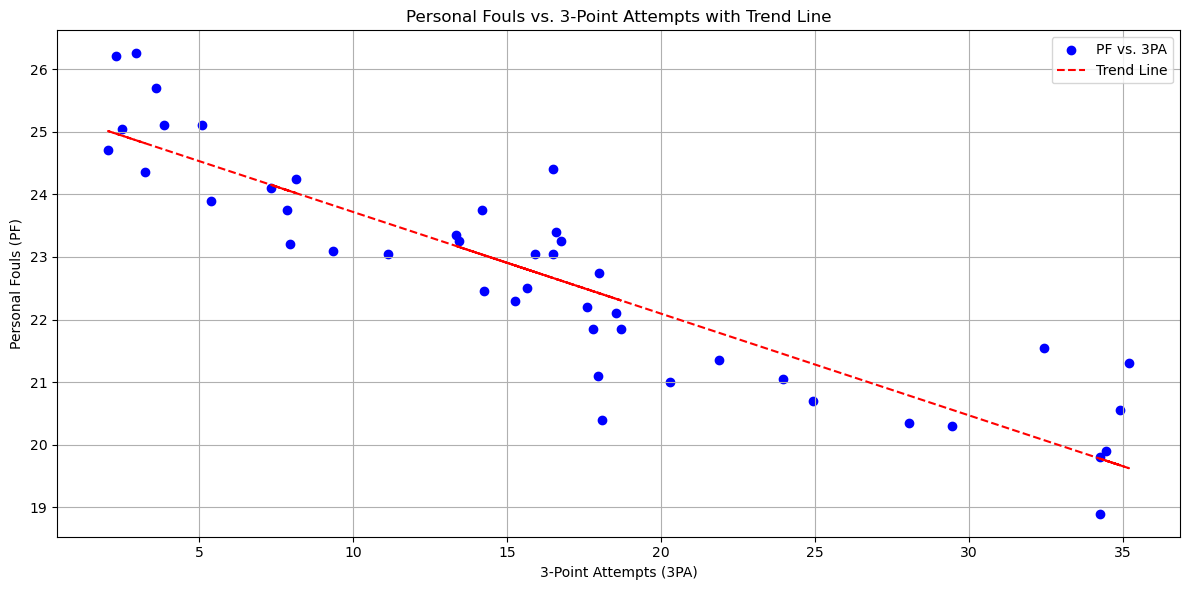

In [27]:
visualize_9()

The trendline demonstrates a negative correlation between Personal Fouls (PF) and Three-Point Attempts (3PA). As the number of 3-point attempts per game has increased, the number of personal fouls has generally decreased. This suggests that teams focusing more on three-point shooting may be playing a less physical game, leading to fewer fouls. It could also reflect a shift in strategy where teams avoid close-contact situations that are more likely to result in fouls, instead prioritizing perimeter shooting. The trend indicates a shift towards a more perimeter-oriented, less aggressive style of play.